# 1.引言
多头注意力是指将注意力机制分为多个“头”，每个头学习数据的不同方面，使模型能够从多个层面来捕获输入序列中各部分之间的关系，这提高了模型在复杂任务中的表现。

本文将在上篇文章因果注意力的基础上，一步一步解读多头注意力的简单实现方法和高效实现方法。

# 2.堆叠实现
多头注意力最直接的实现方法是将多个单头注意力的实例堆叠在一起，如下图所示:
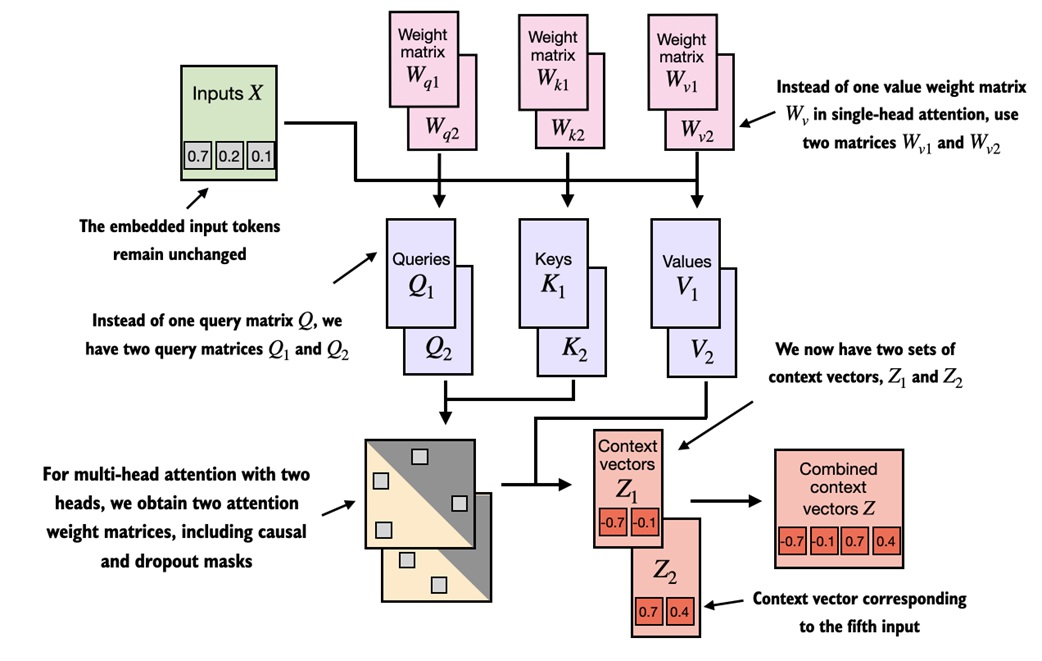
>图中有两个头的多头注意力模块，每个头都有自己的权重矩阵Wq/Wk/Wv，都有自己中间状态Q/K/V，最后合并两组上下文向量Z1/Z2得到上下文向量矩阵Z。

我们通过将前面已经实现的CausalAttention进行堆叠来演示。首先运行已经封装好的attention_v1.py（前文的因果注意力已经封装在里面）。

In [1]:
%run attention_v1.py

定义一个多头注意力类MultiHeadAttentionStack，构造函数与CausalAttention的唯一区别是多了一个num_heads入参，用来指定多头的数量。

In [2]:
from torch import nn

class MultiHeadAttentionStack(nn.Module):
    def __init__(self, dim_in, dim_out, context_length, dropout_rate, num_heads):
        super().__init__()
        # 构建多头注意力
        multi_attens = [CausalAttention(dim_in, dim_out, context_length, dropout_rate)
                       for i in range(num_heads)]
        self.heads = nn.ModuleList(multi_attens)
        
    def forward(self, x):
        context_vecs = [head(x) for head in self.heads]
        return torch.concat(context_vecs, dim=-1)

使用刚封装的多头注意力来计算上下文向量，输出维度设为了2，但由于num_heads=2指定了使用两个头，所以最终的上下文向量是dim_out * num_heads = 4 维。

In [3]:
torch.manual_seed(123)
batch = torch.stack((inputs, inputs), dim=0)
b, token_len, dim = batch.shape 
multi_heads = MultiHeadAttentionStack(dim, 2, token_len, 0.0, num_heads=2)
context_vecs = multi_heads(batch)
context_vecs

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)

> 批量输入张量batch中有两个输入文本，由于两个文本是经过复制而来，因此最终的两个文本的上下文张量完全相同。

这样，我们就通过创建并组合多个CausalAttention类，实现了第一个版本的多头注意力模块。但这个实现方式有两个缺点：

1. 需要关心并维护MultiHeadAttentionStack和CausalAttention两个概念，不够简洁。
2. 多个头在计算注意力时需要按顺序以串行的方式，相当于有多少个头就要计算多少遍注意力，不够高效。

为此，我们接下来将尝试改进这个实现。

# 3.权重分割实现
权重分割的基本思想：将大权重矩阵按照头的数量（num_heads）分割，即能模拟出多头各有一个小的权重矩阵的效果。通过这些小的权重矩阵并行的对输入进行变换，就能一次性计算出所有注意力头的输出。
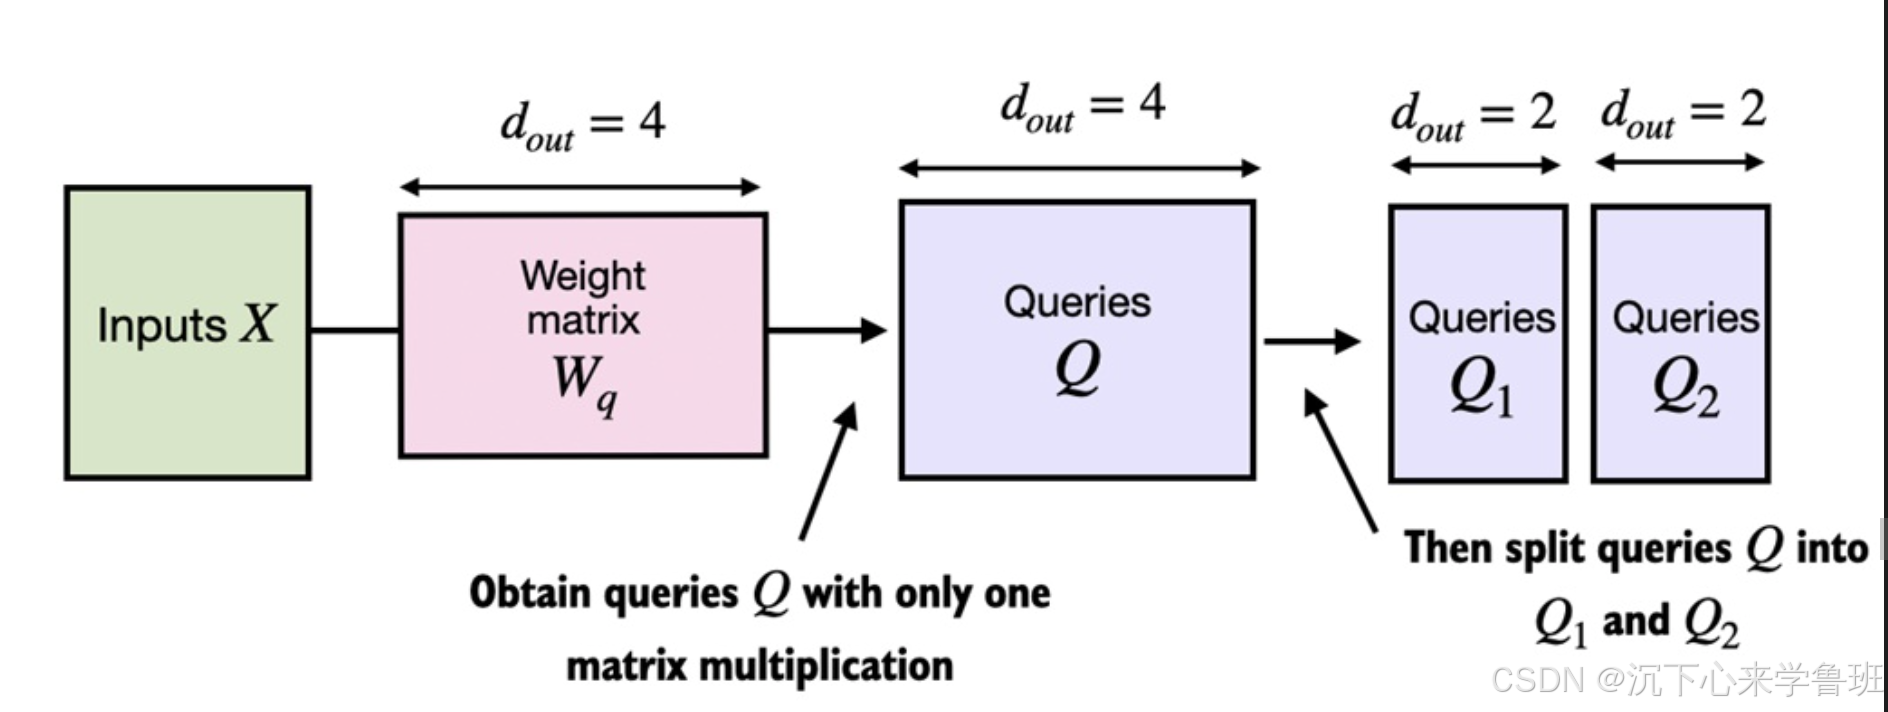
>如上图所示，通过初始化一个大的权重矩阵Wq，只和输入张量X进行一次矩阵乘法来获得查询矩阵Q，然后使用view方法对Q进行形状重塑即可得到多个头。

下面我们来进行代码实现。

## 3.1 多头注意力类
由于多头注意力的代码相对稍长，我们分成构造方法和forward方法两部分来说明。

In [42]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, context_length, dropout_rate, num_heads, qkv_bias=False):
        super().__init__()
        assert dim_out % num_heads == 0, "dim_out must be divisible by num_heads"
        
        self.dim_out = dim_out
        self.num_heads = num_heads
        self.head_dim = dim_out // num_heads   # 每个头的维度
        
        self.Wq = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.Wk = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.Wv = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.Wo = nn.Linear(dim_out, dim_out)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

构造方法__init__与CausalAttention中的实现基本类似，只作了两个小的扩展：

1. 进行了单头维数head_dim的计算，num_heads是多头数量，dim_out是总的输出维度，dim_out/num_heads就是单个头的维度。
2. 增加了一个输出投影层（self.Wo），这个并不是必需，但在许多大语言模型中都常见，所以这里也加进来。

下面对forward方法进行封装，由于需要对矩阵进行分割和重组，所以会涉及到张量的变形（view）和转置（transpose）操作，需要仔细理解每一步运算过后矩阵形状的变化。

In [43]:
def forward(self, x):
    b, num_tokens, dim_in = x.shape
    # 求Q/K/V矩阵，shape为（b, num_tokens, dim_out）
    q = self.Wq(x)
    k = self.Wk(x)
    v = self.Wv(x)
    
    # 多头注意力矩阵分割
    # 变换形状，使用view将dim_out -> num_heads, head_dim
    # shape=(b, num_tokens, num_heads, head_dim)
    q = q.view(b, num_tokens, self.num_heads, self.head_dim)
    k = k.view(b, num_tokens, self.num_heads, self.head_dim)
    v = v.view(b, num_tokens, self.num_heads, self.head_dim)
    
    # 由于计算注意力分数时，需要对每一个头并行计算，这里需要交换第2维和第3维
    # shape：（b, num_heads, num_tokens, self.dim_out）
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)
    
    # 计算注意力分数,shape=(b, num_heads, num_tokens, num_tokens)
    atten_scores = q @ k.transpose(2, 3)
    atten_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    atten_weights = torch.softmax(atten_scores / k.shape[-1] ** 0.5, dim=-1)
    atten_weights = self.dropout(atten_weights)
    
    # 计算上下文张量
    context_vecs = atten_weights @ v  # shape=(b, num_heads, num_tokens, head_dim)
    context_vecs = context_vecs.transpose(1, 2)  # shape=(b, num_tokens, num_heads, head_dim)
    context_vecs = context_vecs.contiguous().view(b, num_tokens, self.dim_out)
    print(context_vecs.shape)
    print(self.Wo)
    output = self.Wo(context_vecs)
    
    return output

setattr(MultiHeadAttention, "forward", forward)

几个关注步骤的理解:

1. 关键操作是将dim_out维度分割为num_heads和head_dim，这个分割操作由view方法实现，将维度为(b, num_tokens, dim_out)的张量q、k、v重塑为维度(b, num_tokens, num_heads, head_dim),即将一个大的head切割成了多头。
2. 随后进行了张量转置操作，将多头维度num_heads排在了序列长度num_tokens之前，张量形状变为（b, num_heads, num_tokens, head_dim），正是由于这个转置，使得多个头可以一次性进行批量矩阵乘法，一次性得出所有上下文向量。
3. 最后将两个维度num_heads和num_tokens恢复位置，形状变回(b, num_tokens, num_heads, head_dim)，再通过view操作将多个头的上下文向量合并，向量被重塑（扁平化）成 (b, num_tokens, dim_out) 的形状。

> contiguous方法：张量在某些复杂操作（例如转置、切片）之后可能会变得不连续，而view方法需要连续的内存才能正常工作，contiguous方法的作用就是确保返回一个在内存中连续的张量。

## 3.3 多头注意力使用
下面用之前两个序列的输入来示例MultiHeadAttention的使用。

In [44]:
torch.manual_seed(123)
b, num_tokens, dim_in = batch.shape

b, num_tokens, dim_in

(2, 6, 3)

In [45]:
multi_heads = MultiHeadAttention(dim_in, 4, num_tokens, 0.0, 2)
context_vecs = multi_heads(batch)
context_vecs

torch.Size([2, 6, 4])
Linear(in_features=4, out_features=4, bias=True)


tensor([[[ 0.1184,  0.3120, -0.0847, -0.5774],
         [ 0.0178,  0.3221, -0.0763, -0.4225],
         [-0.0147,  0.3259, -0.0734, -0.3721],
         [-0.0116,  0.3138, -0.0708, -0.3624],
         [-0.0117,  0.2973, -0.0698, -0.3543],
         [-0.0132,  0.2990, -0.0689, -0.3490]],

        [[ 0.1184,  0.3120, -0.0847, -0.5774],
         [ 0.0178,  0.3221, -0.0763, -0.4225],
         [-0.0147,  0.3259, -0.0734, -0.3721],
         [-0.0116,  0.3138, -0.0708, -0.3624],
         [-0.0117,  0.2973, -0.0698, -0.3543],
         [-0.0132,  0.2990, -0.0689, -0.3490]]], grad_fn=<ViewBackward0>)